### This notebook extends the TensorFlow Recommender tutorial and uses the following techniques: two-tower retrieval, incorporating rich features, and multi-task learning

Real-world recommender systems are often composed of two stages:
- The retrieval stage is responsible for selecting an initial set of hundreds of candidates from all possible candidates. The main objective of this model is to efficiently weed out all candidates that the user is not interested in. Because the retrieval model may be dealing with millions of candidates, it has to be computationally efficient.
- The ranking stage takes the outputs of the retrieval model and fine-tunes them to select the best possible handful of recommendations. Its task is to narrow down the set of items the user may be interested in to a shortlist of likely candidates.

### Retrieval (two-tower) model structure (https://www.tensorflow.org/recommenders/examples/deep_recommenders)
- Get user_embedding from User/Query Model
    1. Embedding
        - User ID embedding
        - (optional) Timestamp discretizing and embedding
        - (optional) Normalized timestamp
    2. Concatenate the embeddings above, and feed through a few dense layers (Use ReLU for all layers except for the last layer which has no activation function) which outputs user_embedding. These dense layers are needed if the optional features are included
- Get product_embedding from Product/Candidate Model
    1. Embedding
        - Product title embedding
        - (optional) Product title tokenizing, embedding, and then Averaging Pooling (may use Transformers instead)
    2. Concatenate the embeddings above, and feed through a few dense layers (Use ReLU for all layers except for the last layer which has no activation function) which outputs product_embedding. These dense layers are needed if the optional features are included
- Specify FactorizedTopK(user_embedding, product_embedding) that computes metrics for across top K candidates surfaced by a retrieval model. The goal is to predict whether a user will or will not buy a product

### Ranking model structure (https://www.tensorflow.org/recommenders/examples/basic_ranking)
- Get rating_predictions from Ranking Model
    1. Embedding
        - User ID embedding
        - Product title embedding
    2. Concatenate User ID embedding and Product title embedding, and feed through a few dense layers (Use ReLU for all layers except for the last layer which has no activation function) which outputs rating_predictions
- Specify MeanSquaredError(labels, rating_predictions) loss. The goal is to predict the ratings as accurately as possible
            
### Multitask model structure (https://www.tensorflow.org/recommenders/examples/multitask)
- Get User ID embedding, Product title embedding, and rating_predictions from Multitask model
    1. Embedding
        - User ID embedding
        - Product title embedding
    2. Concatenate User ID embedding and Product title embedding, and feed through a few dense layers (Use ReLU for all layers except for the last layer which has no activation function) which outputs rating_predictions
- Specify FactorizedTopK(User ID embedding, Product title embedding) that computes metrics for across top K candidates surfaced by a retrieval model. The goal is to predict whether a user will or will not buy a product
- Specify MeanSquaredError(labels, rating_predictions) loss. The goal is to predict the ratings as accurately as possible

# Structure of the model in this notebook
- Get user_embedding, product_embedding, and rating_predictions from Multitask model
    1. Embedding
        - Get user_embedding from User/Query Model
            1. Embedding
                - User ID embedding
                - (optional) Timestamp discretizing and embedding
                - (optional) Normalized timestamp
            2. Concatenate the embeddings above, and feed through a few dense layers (Use ReLU for all layers except for the last layer which has no activation function) which outputs user_embedding. These dense layers are needed if the optional features are included
        - Get product_embedding from Product/Candidate Model
            1. Embedding
                - Product title embedding
                - (optional) Product title tokenizing, embedding, and then Averaging Pooling (may use Transformers instead)
            2. Concatenate the embeddings above, and feed through a few dense layers (Use ReLU for all layers except for the last layer which has no activation function) which outputs product_embedding. These dense layers are needed if the optional features are included
    2. Concatenate user_embedding and product_embedding, and feed through a few dense layers (Use ReLU for all layers except for the last layer which has no activation function) which outputs rating_predictions
- Specify FactorizedTopK(user_embedding, product_embedding) that computes metrics for across top K candidates surfaced by a retrieval model. The goal is to predict whether a user will or will not buy a product
- Specify MeanSquaredError(labels, rating_predictions) loss. The goal is to predict the ratings as accurately as possible

In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-bsl 1.10.1 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.61.0 which is incompatible.
tfx-bsl 1.10.1 requires pyarrow<7,>=6, but you have pyarrow 9.0.0 which is incompatible.
tensorflow-transform 1.10.1 requires pyarrow<7,>=6, but you have pyarrow 9.0.0 which is incompatible.
tensorflow-serving-api 2.10.0 requires tensorflow<3,>=2.10.0, but you have tensorflow 2.9.2 which is incompatible.
ortools 9.5.2237 requires protobuf>=4.21.5, but you have protobuf 3.19.6 which is incompatible.
onnx 1.13.0 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
google-cloud-logging 3.2.2 requires google-cloud-core<3.0.0dev,>=2.0.0, but you have google-cloud-core

In [1]:
import os
import pprint
import tempfile

from typing import Dict, Text

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

%matplotlib inline

In [3]:
ratings = tfds.load('movielens/100k-ratings', split="train")
movies = tfds.load('movielens/100k-movies', split="train")

# Select the basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    "timestamp": x["timestamp"]
})
movies = movies.map(lambda x: x["movie_title"])

2023-02-18 16:50:22.855548: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/0.1.1.incompleteT76UG4/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


2023-02-18 16:51:16.241821: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64::/opt/conda/lib
2023-02-18 16:51:16.241883: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-movies/0.1.1.incompleteBFA3Y9/movielens-train.tfrecord*...:…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.1. Subsequent calls will reuse this data.


### Prepare data

In [4]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

### Prepare feature vocabularies

In [5]:
timestamps = np.concatenate(list(ratings.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))
unique_user_ids = np.unique(
    np.concatenate(
        list(ratings.batch(1_000).map(lambda x: x["user_id"]))
    )
)

### Define models

In [6]:
class UserModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
        ])
        self.timestamp_embedding = tf.keras.Sequential([
            tf.keras.layers.Discretization(timestamp_buckets.tolist()),
            tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
        ])
        self.normalized_timestamp = tf.keras.layers.Normalization(
            axis=None
        )

        self.normalized_timestamp.adapt(timestamps)

    def call(self, inputs):
        # Take the input dictionary, pass it through each input layer,
        # and concatenate the result
        return tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.timestamp_embedding(inputs["timestamp"]),
            tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1)),
        ], axis=1)


class QueryModel(tf.keras.Model):
    """Model for encoding user queries."""

    def __init__(self, layer_sizes):
        """Model for encoding user queries.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        # First use the user model for generating embeddings
        self.embedding_model = UserModel()

        # Then construct the layers
        self.dense_layers = tf.keras.Sequential()

        # Use the ReLU activation for all but the last layer
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # No activation for the last layer
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)


class MovieModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        max_tokens = 10_000

        self.title_embedding = tf.keras.Sequential([
          tf.keras.layers.StringLookup(
              vocabulary=unique_movie_titles,mask_token=None),
          tf.keras.layers.Embedding(len(unique_movie_titles) + 1, 32)
        ])

        self.title_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=max_tokens)

        self.title_text_embedding = tf.keras.Sequential([
          self.title_vectorizer,
          tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
          tf.keras.layers.GlobalAveragePooling1D(),
        ])

        self.title_vectorizer.adapt(movies)

    def call(self, titles):
        return tf.concat([
            self.title_embedding(titles),
            self.title_text_embedding(titles),
        ], axis=1)


class CandidateModel(tf.keras.Model):
    """Model for encoding movies."""

    def __init__(self, layer_sizes):
        """Model for encoding movies.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        # First use the movie model for generating embeddings
        self.embedding_model = MovieModel()

        # Then construct the layers
        self.dense_layers = tf.keras.Sequential()

        # Use the ReLU activation for all but the last layer
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # No activation for the last layer
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)


class MovielensModel(tfrs.models.Model):

    def __init__(self, layer_sizes: float, rating_weight: float, retrieval_weight: float) -> None:
        super().__init__()
        self.query_model = QueryModel(layer_sizes)
        self.candidate_model = CandidateModel(layer_sizes)
        # A small model to take in user and movie embeddings and predict ratings.
        # We can make this as complicated as we want as long as we output a scalar
        # as our prediction
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(16, activation="relu"),
            tf.keras.layers.Dense(1),
        ])
        # The tasks
        self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )
        self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=movies.batch(128).map(self.candidate_model)
            )
        )
        # The loss weights
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight
        
    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
        # Pick out the user features and pass them into the user model
        user_embeddings = self.query_model({
            "user_id": features["user_id"],
            "timestamp": features["timestamp"]
        })
        # Pick out the movie features and pass them into the movie model
        movie_embeddings = self.candidate_model(features["movie_title"])

        return (
            user_embeddings,
            movie_embeddings,
            # Apply the multi-layered rating model to a concatentation of
            # user and movie embeddings
            self.rating_model(
                tf.concat([user_embeddings, movie_embeddings], axis=1)
            )
        )

    def compute_loss(self, features, training=False):

        ratings = features.pop("user_rating")

        user_embeddings, movie_embeddings, rating_predictions = self(features)

        # Compute the loss for each task
        rating_loss = self.rating_task(
            labels=ratings,
            predictions=rating_predictions,
        )
        retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings, compute_metrics=not training)

        # Combine them using the loss weights
        return (
            self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss
        )

### Train

In [7]:
model = MovielensModel(layer_sizes=[64, 32], rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=50,
    verbose=0
)

accuracy = history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
root_mean_squared_error = history.history["val_root_mean_squared_error"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")
print(f"Ranking RMSE: {root_mean_squared_error:.2f}.")

Top-100 accuracy: 0.26.
Ranking RMSE: 1.03.


### A Multitask model can perform well on both Retrieval and Ranking. It is most useful when transferring knowledge from a data-abundant task (such as clicks) to a closely related data-sparse task (such as purchases).

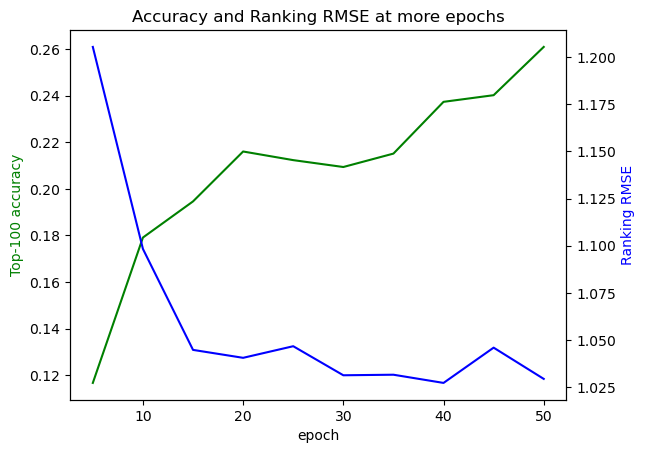

In [8]:
num_validation_runs = len(history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(epochs, history.history["val_factorized_top_k/top_100_categorical_accuracy"], 'g-')
ax2.plot(epochs, history.history["val_root_mean_squared_error"], 'b-')
ax1.set_xlabel('epoch')
ax1.set_ylabel('Top-100 accuracy', color='g')
ax2.set_ylabel('Ranking RMSE', color='b')

plt.title("Accuracy and Ranking RMSE at more epochs")
plt.show()

### Make prediction

In [9]:
trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
    "user_id": np.array(["42"]),
    "movie_title": np.array(["Dances with Wolves (1990)"]),
    "timestamp": np.array([893286638])
})
print("Predicted rating:")
print(predicted_rating)

Predicted rating:
tf.Tensor([[3.6073005]], shape=(1, 1), dtype=float32)
